In [4]:
import calim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import scipy

import sys
import os
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path+"\\custom_functs")

from modules import customfunctions as cf

#styles for error and markers in sns.lineplot

thin_custom_lw = 1.2
custom_lw = thin_custom_lw/0.65

filled_marker_style = dict(marker='o',  markersize=5,
                           color='k',
                           markerfacecolor='w',
                           markeredgecolor='k',
                          markeredgewidth=thin_custom_lw)

filled_marker_style_white = dict(marker='o',  markersize=5,
                           color='w',
                           markerfacecolor='w',
                           markeredgecolor='w',
                          markeredgewidth=custom_lw)


error_style_white = {"capsize": 4.4, 
                "ecolor": "w",
               "barsabove":False, 
               "elinewidth":custom_lw, 
               "capthick":custom_lw,
                    "zorder": 8}

error_style = {"capsize": 4, 
                "ecolor": "k",
                "barsabove":False, 
                "elinewidth":thin_custom_lw, 
                "capthick":thin_custom_lw,
                "zorder": 9}




In [5]:
# number of iterations and seed for bootstrapping during calculation of confidence intervals
n_boot = 10000
seed = 10

In [8]:
filename_KO = "Cacna1hKO_KO_295_Cal520.hdf"
filename_WT = "Cacna1hKO_WT_295_Cal520.hdf"



data_KO = calim.Project()
data_WT = calim.Project()
data_KO.from_hdf(filename_KO)
data_WT.from_hdf(filename_WT)

In [9]:
print("Start")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

#cutoff for burst parameters
co_WT = 3.737 
co_KO = 1.759

data = pd.DataFrame()
for file in [data_WT, data_KO]:
    print(f"Processing recordings for {file}:")
    for recording in file.recordings:
        print(recording)

        r = file.recordings[recording]
        
        # go through all cells
        for cell in r.cells:    
            # get recording information
            info = {desc: r.information[desc] for desc in r.information}

            c = r.cells[cell]


            if c.use:
                print(cell)

                # go through all conditions
                for con in r.conditions:

                    # get con infromation
                    info["recording"] = recording
                    info["start"] = int(con.start) 
                    info["cell"] = cell
                    info["dt"] = r.dt # Add "dt" aka seconds/frame                

                    info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables           

                    start = int(con.start)
                    end = int(con.end)
                    
                    if (end-start)*r.dt > 450: #cutoff segment after 7.5 min (450 seconds)
                        end = int(start+(450/r.dt))
                    
                    end_5min = int(start + (300/r.dt)) # add 300 seconds
                    info["end"] = end
                    info["len_seg"] = (end-start)*r.dt

                    
                    
                    # calculate activity
                    info["num_events"]  = len(list(c.get_event(range(start, end)))) # Number of events
                    if info["num_events"]  == 0:
                        continue
                    else:
                        info["activity"] = (info["num_events"]/(end-start))/r.dt # Events/s
                            
                    info["num_events_5min"] = len(list(c.get_event(range(start, end_5min)))) # Number of events first 5 min
                    info["activity_5min"] = (info["num_events_5min"]/(end_5min-start))/r.dt # Events/s
                    
                    #set cutoff for burst partameters depending on genotype
                    if info["genotype"] == "wt":
                        cutoff = co_WT
                    elif info["genotype"] == "KO":
                        cutoff = co_KO
                    else:
                        print("!!!!")
                        cutoff = np.nan
                    #get burst parameters
                    list_bursts, list_ISI = cf.getBursts(list(c.get_event(list(range(start, end)))),\
                                                         dt=r.dt, maxEventLength=cutoff)
                    
                    
                   
                    #print(list_ISI)
                    if len(list_ISI) == 0:
                        info["ISI"] = np.nan
                    else:
                        info["ISI"] = list_ISI["frame"].diff().iloc[1::2].mean()*r.dt
                        
                    #print(info["ISI"] )

                    list_bursts = list_bursts.reset_index(drop=True)
                           
                    if len(list_bursts) == 0:
                        info["intraburst_freq"] = np.nan
                        info["burst_num_spikes"] = np.nan
                        info["burst_length"] = np.nan
                        info["burst_n"] = np.nan
                        info["burst_per_cell_per_sec"] = np.nan
                        
                        
                    info["intraburst_freq"], \
                    info["burst_num_spikes"], \
                    info["burst_length"], \
                    info["burst_n"], \
                    info["burst_per_cell_per_sec"] = cf.getBurstParams(list_bursts,r.dt, cutoff,start, end)
                    
                    data = pd.concat((data, pd.DataFrame.from_dict(info, orient="index").T), ignore_index=True)
                    #data = data.append(pd.Series(info), ignore_index=True)





print("Done")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

data.to_csv("data_Calbryte_activity_burstparam_230320.csv")
print("Save data to data_Calbryte_activity_burstparam_230320.csv")

Start
###### date and time ######
18-Apr-2023 14:51
Processing recordings for <calim.Project object at 0x0000023E2FB09DB0>:
200526_s1r2_Results.csv
Mean10
Mean11
Mean12
Mean2
Mean3
Mean4
Mean5
Mean6
Mean7
Mean8
Mean9
200610_s2r1_Results.csv
Mean1
Mean10
Mean11
Mean12
Mean13
Mean14
Mean15
Mean16
Mean17
Mean18
Mean19
Mean2
Mean20
Mean21
Mean3
Mean4
Mean6
Mean7
Mean8
Mean9
200610_s3r1_Results.csv
Mean1
Mean10
Mean11
Mean12
Mean13
Mean14
Mean15
Mean16
Mean17
Mean18
Mean2
Mean4
Mean5
Mean6
Mean7
Mean8
Mean9
200610_s4r1_Results.csv
Mean1
Mean10
Mean11
Mean12
Mean13
Mean14
Mean15
Mean16
Mean17
Mean18
Mean19
Mean2
Mean20
Mean21
Mean22
Mean23
Mean24
Mean25
Mean26
Mean27
Mean28
Mean29
Mean3
Mean4
Mean5
Mean6
Mean7
Mean8
Mean9
200610_s5r1_Results.csv
Mean1
Mean10
Mean11
Mean12
Mean13
Mean14
Mean15
Mean16
Mean17
Mean18
Mean19
Mean2
Mean20
Mean21
Mean22
Mean23
Mean24
Mean25
Mean26
Mean27
Mean28
Mean29
Mean3
Mean30
Mean31
Mean32
Mean4
Mean5
Mean6
Mean7
Mean8
Mean9
200610_s6r1_Results.csv
Mean1
Mean1

# Load Data

In [10]:
cols = ["genotype", "angiotensin", "potassium","recording","dt", "animal", "sex", "cell","pos",
        "activity","activity_5min","intraburst_freq", "burst_length","burst_per_cell_per_sec","ISI","len_seg"]
data = pd.read_csv("data_Calbryte_activity_burstparam_230320.csv", usecols=cols)  
print("Load data")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

Load data
###### date and time ######
18-Apr-2023 14:59


In [11]:
#filter data
data = data.groupby(["angiotensin", "potassium"]).get_group((500,4))
# remove data with low activity
data_act_corr = data[data["activity_5min"]>= 0.17]
len(data_act_corr)
# keep recording with at least 6 cells 
drop_rec = data_act_corr.groupby(["genotype", "recording"])\
            .count().reset_index().query("cell<6").recording.unique()
data_act_corr = data_act_corr[~data_act_corr.recording.isin(drop_rec)]

In [13]:
# annotate number of cells whithhin a recording and pos that have intraburst_freq 
data_act_corr["freq_exist"] = data_act_corr["intraburst_freq"]-data_act_corr["intraburst_freq"]+1
n_freq = data_act_corr[["recording", "pos","freq_exist"]].value_counts(dropna=False).reset_index(name='f_count')\
                    .query("freq_exist==1")[["recording", "pos", "f_count"]]
data_act_corr = pd.merge(data_act_corr, n_freq, on=["recording", "pos"])


311


In [14]:
# annotate number of cells whithhin a recording and pos that have burst lenght 
data_act_corr["burstL_exist"] = data_act_corr["burst_length"]-data_act_corr["burst_length"]+1
n_burstL = data_act_corr[["recording", "pos","burstL_exist"]].value_counts(dropna=False).reset_index(name='b_count')\
                    .query("burstL_exist==1")[["recording", "pos", "b_count"]]
data_act_corr = pd.merge(data_act_corr, n_burstL, on=["recording", "pos"])


311


In [15]:
# annotate number of cells whithhin a recording and pos that have burst lenght 
data_act_corr["isi_exist"] = data_act_corr["ISI"]-data_act_corr["ISI"]+1
n_ISI = data_act_corr[["recording", "pos","isi_exist"]].value_counts(dropna=False).reset_index(name='isi_count')\
                    .query("isi_exist==1")[["recording", "pos", "isi_count"]]
data_act_corr = pd.merge(data_act_corr, n_ISI, on=["recording", "pos"])


311


In [17]:
df_n_animal_rec_cell = pd.concat([data_act_corr.groupby(["genotype"]).nunique().animal, 
           data_act_corr.groupby(["genotype"]).nunique().recording,
           data_act_corr.groupby(["genotype"]).count().cell],
         axis=1).reindex(['wt', 'KO'])
df_n_animal_rec_cell

,animal,recording,cell
genotype,,,
wt,7,11,208
KO,5,7,103


In [18]:
#calculate number of cells
cell_data = pd.DataFrame(data_act_corr.groupby(["genotype", "animal", "recording"]).nunique().cell)

In [19]:
#reshape data to per slice analysis
df_recs = data_act_corr[["recording", "genotype", "animal"]].drop_duplicates().set_index('recording')
df_per_slice = data_act_corr.groupby(["recording"]).mean().reset_index()
df_per_slice = df_per_slice.join(df_recs, on="recording")
df_per_slice.to_csv("df_per_slice_Calbryte_activity_burstparam_7p5_230320.csv")

C:\Users\dinhha\AppData\Local\Temp\ipykernel_3344\1769581806.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_per_slice = data_act_corr.groupby(["recording"]).mean().reset_index()


In [20]:
#save data
data_act_corr.to_csv("data_filtered_Calbryte_activity_burstparam_230220.csv")
cell_data.reset_index().to_csv("data_Calbryte_cell_data_2300320.csv")

In [23]:
print(data_act_corr.groupby(["genotype"]).mean().activity)
print(data_act_corr.query("f_count>5").groupby(["genotype"]).mean().intraburst_freq)
print(data_act_corr.query("b_count>5").groupby(["genotype"]).mean().burst_length)
print(data_act_corr.query("isi_count>5").groupby(["genotype"]).mean().ISI)

genotype
KO    1.006947
wt    0.483793
Name: activity, dtype: float64
genotype
KO    1.317785
wt    0.881153
Name: intraburst_freq, dtype: float64
genotype
KO    70.775561
wt    81.293040
Name: burst_length, dtype: float64
genotype
KO    41.632976
wt    63.530516
Name: ISI, dtype: float64


C:\Users\dinhha\AppData\Local\Temp\ipykernel_3344\1753755992.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(data_act_corr.groupby(["genotype"]).mean().activity)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_3344\1753755992.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(data_act_corr.query("f_count>5").groupby(["genotype"]).mean().intraburst_freq)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_3344\1753755992.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or 

# $\Downarrow$ Activity  $\Downarrow$

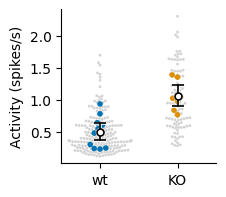

In [26]:
y = "activity"
data = df_per_slice.dropna(subset=[y])


fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype", y=y, data=data, 
                  order=["wt", "KO"],
               hue="genotype", 
                  palette=(color_palette[1], color_palette[0]),
               s=4, zorder=2)

sns.swarmplot(x="genotype", y=y, data=data_act_corr.dropna(subset=[y]), 
                  order=["wt", "KO"],
               hue="genotype", palette=("lightgrey", "lightgrey"),
               s=2, zorder=1)


sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)
#plt.ylim(0, 2.5)
plt.xlim(-0.5, 1.5)

g.set_ylabel("Activity (spikes/s)")
g.set_xlabel("")

plt.legend([],[], frameon=False)
plt.show()

# $\Downarrow$ Burst Parameter  $\Downarrow$

$\Downarrow$ intraburst freq   $\Downarrow$

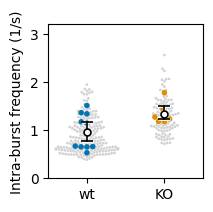

In [27]:
y = "intraburst_freq"
data = df_per_slice.dropna(subset=[y]).query("f_count>5")

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype", y=y, data=data, order=["wt","KO"],hue_order=["wt","KO"],
                hue="genotype", palette=(color_palette[0], color_palette[1]),
              s=4, zorder=2)

sns.swarmplot(x="genotype", y=y, data=data_act_corr.dropna(subset=[y]), 
                     order=["wt","KO"], hue_order=["wt","KO"],
              hue="genotype", palette=("lightgrey", "lightgrey"),
               s=2, zorder=1)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

plt.ylim(0, 3.2)
plt.xlim(-0.5, 1.5)

g.set_ylabel("Intra-burst frequency (1/s)")
g.set_xlabel("")
plt.legend([],[], frameon=False)

plt.show()

$\Downarrow$ Burst length   $\Downarrow$

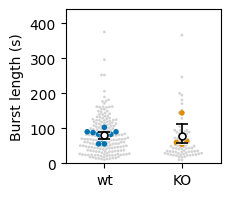

In [28]:
y = "burst_length"
data = df_per_slice.dropna(subset=[y]).query("b_count>5")

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype", y=y, data=data, order=["wt","KO"],hue_order=["wt","KO"],
                hue="genotype", palette=(color_palette[0], color_palette[1]),
              s=4, zorder=2)

sns.swarmplot(x="genotype", y=y, data=data_act_corr.dropna(subset=[y]), 
                  order=["wt", "KO"], hue_order=["wt","KO"],
               hue="genotype", palette=("lightgrey", "lightgrey"),
               s=2, zorder=1)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

plt.ylim(0, 440)
plt.xlim(-0.5, 1.5)




g.set_ylabel("Burst length (s)")
g.set_xlabel("")
plt.legend([],[], frameon=False)

plt.show()

$\Downarrow$ Inter-burst interval  $\Downarrow$

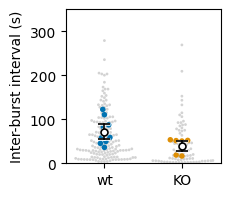

In [29]:
y = "ISI"
data = df_per_slice.dropna(subset=[y]).query("isi_count>5")

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype", y=y, data=data, order=["wt","KO"],hue_order=["wt","KO"],
                hue="genotype", palette=(color_palette[0], color_palette[1]),
              s=4, zorder=2)

sns.swarmplot(x="genotype", y=y, data=data_act_corr.dropna(subset=[y]), 
                    order=["wt","KO"],hue_order=["wt","KO"],
              hue="genotype", palette=("lightgrey", "lightgrey"),
               s=2, zorder=1)


sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)
plt.xlim(-0.5, 1.5)
plt.ylim(0, 350)

g.set_ylabel("Inter-burst interval (s)")
g.set_xlabel("")
plt.legend([],[], frameon=False)

plt.show()

# numbers of cells $\Downarrow$

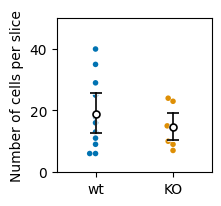

In [34]:
fig, g = plt.subplots(figsize=(2, 2))

g =  sns.swarmplot(x="genotype", y="cell", data=cell_data.reset_index(),  order=["wt", "KO"],
                 hue="genotype", palette=(color_palette[1], color_palette[0]),
                 s=4, zorder=1, legend=False)

sns.lineplot(x="genotype", y="cell", data=cell_data.reset_index().sort_values(by=['genotype'], ascending=False),
             lw=0, sort=False,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y="cell", data=cell_data.reset_index(), lw=0, 
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

plt.ylim(-0.1, 50)
plt.xlim(-0.5, 1.5)


g.set_ylabel("Number of cells per slice")
g.set_xlabel("") 

plt.show()